In [1]:
# import sqlite3
import pandas as pd
import numpy as np
import math
from time import time
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import category_encoders as ce
import scipy
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy import sparse
from scipy.sparse import hstack

# import logging  # Setting up the loggings to monitor gensim
# logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [ ]:
fakenews_df = pd.read_pickle("pickle_file")

fakenews_df = fakenews_df.sample(frac=1,random_state=419).reset_index(drop=True) # random shuffle
fakenews_df['scaled_text_length'] = preprocessing.MinMaxScaler().fit_transform(fakenews_df[['text_length']])
encoder = ce.BinaryEncoder(cols=fakenews_df[['type', 'site_name', 'authors']],return_df=True)
fakenews_df_encoded=encoder.fit_transform(fakenews_df[['type', 'site_name', 'authors']])
fakenews_df=pd.concat([fakenews_df.reset_index(drop=True),fakenews_df_encoded.reset_index(drop=True)], axis = 1)

print(len(fakenews_df.normal_text))
print(fakenews_df.groupby('fake').count())


# Addition of Weighted Title in Features

In [3]:
normal_text = 6 * (fakenews_df.normal_title) + fakenews_df.normal_text #+ fakenews_df.site_name  #+ (6 * (fakenews_df.adverbs + fakenews_df.adj)) # + fakenews_df.ner #+ fakenews_df.adj + fakenews_df.adverbs #
news_type = fakenews_df.fake.apply(int).tolist()


In [4]:
# splitting data for training and testing
# bins = np.arange(5)
# binned_y = np.digitize(news_type, bins)

np.random.seed(11)
x_train, x_test, y_train, y_test = train_test_split(normal_text, news_type, test_size=0.2, random_state=1) #stratify=binned_y)
news_token, test_token = x_train, x_test
x_train = x_train.apply(' '.join).tolist()
x_test = x_test.apply(' '.join).tolist()

print(news_token[:1])
print(test_token[:1])

8900    [golden, globes, big, tv, nomination, snub, su...
dtype: object
9260    [mariah, world, mariah, carey, nbcuniversal, m...
dtype: object


In [9]:
vec = CountVectorizer(input='content',strip_accents='unicode',lowercase=True,ngram_range=(1,3),max_df=0.70,min_df=1)
idf = TfidfTransformer()

NameError: name 'CountVectorizer' is not defined

Support Vector Classifier
accuracy:   87.609
Root Mean Square:   0.352
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2280
           1       0.78      0.66      0.72       714

    accuracy                           0.88      2994
   macro avg       0.84      0.80      0.82      2994
weighted avg       0.87      0.88      0.87      2994



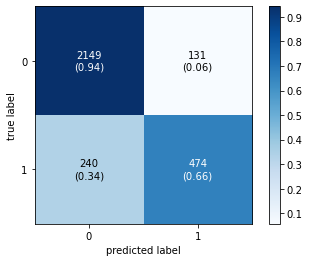

In [6]:
# SVM

clf = LinearSVC()
pipe_svc = Pipeline([
    ('vect', vec),
    ('tfidf', idf),
    ('clf', clf)
])

model = pipe_svc.fit(x_train, y_train)
prediction = model.predict(x_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
rmse = math.sqrt(metrics.mean_squared_error(y_test, prediction))
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print("Root Mean Square:   %0.3f" % (rmse))
print(f1score)
cm = metrics.confusion_matrix(y_test, prediction, labels=[0, 1])

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Passive Aggressive Classifier
accuracy:   87.341
Root Mean Square:   0.356
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2280
           1       0.76      0.69      0.72       714

    accuracy                           0.87      2994
   macro avg       0.83      0.81      0.82      2994
weighted avg       0.87      0.87      0.87      2994



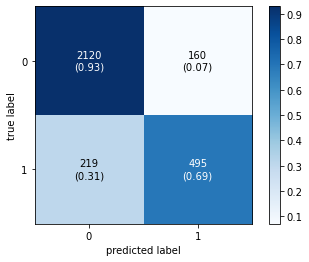

In [7]:
# Passive Aggressive Classifier

pipe_pac = Pipeline([
    ('vect', vec),
    ('tfidf', idf),
    ('clf', PassiveAggressiveClassifier(n_jobs=-1))
])

model = pipe_pac.fit(x_train, y_train)
prediction = model.predict(x_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
rmse = math.sqrt(metrics.mean_squared_error(y_test, prediction))
print('Passive Aggressive Classifier')
print("accuracy:   %0.3f" % (score * 100))
print("Root Mean Square:   %0.3f" % (rmse))
print(f1score)
cm = metrics.confusion_matrix(y_test, prediction, labels=[0, 1])

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()



# Recursive Feature Elimination

In [ ]:
# Recursive Feature Elimination
t = time()

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# feature extraction
def get_tfidf(text):
    vect = CountVectorizer(input='content',strip_accents='unicode',max_features=1000,lowercase=True,ngram_range=(1,3),max_df=0.70,min_df=1).fit_transform(text)
    text_tfidf = TfidfTransformer().fit_transform(vect)
    return text_tfidf

model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 100)
fit = rfe.fit(get_tfidf(x_train), y_train)

x_train_rfe = rfe.transform(get_tfidf(x_train))
x_test_rfe = rfe.transform(get_tfidf(x_test))

print('Model computation time: {} mins'.format(round((time() - t) / 60, 2)))

C:\ProgramData\Anaconda3\envs\Group2Project\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=100 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [ ]:
# SVM
clf = LinearSVC()
pipe_svc = Pipeline([
    ('clf', clf)
])

model = pipe_svc.fit(x_train_rfe, y_train)
prediction = model.predict(x_test_rfe)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
rmse = math.sqrt(metrics.mean_squared_error(y_test, prediction))
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print("Root Mean Square:   %0.3f" % (rmse))
print(f1score)
cm = metrics.confusion_matrix(y_test, prediction, labels=[0, 1])

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
# Passive Aggressive Classifier

pipe_pac = Pipeline([
    ('clf', PassiveAggressiveClassifier(n_jobs=-1))
])

model = pipe_pac.fit(x_train_rfe, y_train)
prediction = model.predict(x_test_rfe)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
rmse = math.sqrt(metrics.mean_squared_error(y_test, prediction))
print('Passive Aggressive Classifier')
print("accuracy:   %0.3f" % (score * 100))
print("Root Mean Square:   %0.3f" % (rmse))
print(f1score)
cm = metrics.confusion_matrix(y_test, prediction, labels=[0, 1])

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()


# Base Models with TFIDF + Metadata

### In this section we will incorporate the metadata also into the features and use it for modeling and prediction.

In [8]:
df=fakenews_df.copy()
vec = CountVectorizer(input='content',strip_accents='unicode',lowercase=True,ngram_range=(1,3),max_df=0.70,min_df=1)
idf = TfidfTransformer()

In [9]:
df.drop('index',axis=1,inplace=True)
df.drop('text',axis=1,inplace=True)
df.drop('title',axis=1,inplace=True)
df.drop('proper_nouns',axis=1,inplace=True)
df.drop('verbs',axis=1,inplace=True)
df.drop('adj',axis=1,inplace=True)
df.drop('ner',axis=1,inplace=True)
df.drop('adverbs',axis=1,inplace=True)
df.drop('site_name',axis=1,inplace=True)
df.drop('text_length',axis=1,inplace=True)
df.drop('type',axis=1,inplace=True)
df.drop('authors',axis=1,inplace=True)

df['normal_text'] = 6 * (df.normal_title) + df.normal_text
df['news_type'] = fakenews_df.fake.apply(int).tolist()
df['normal_text'] = df['normal_text'].apply(' '.join)

df.drop('fake',axis=1,inplace=True)
df.drop('normal_title',axis=1,inplace=True)


In [10]:
# splitting data for training and testing

np.random.seed(11)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1) 

In [11]:
pipe_tfidf = Pipeline([
    ('vect', vec),
    ('tfidf', idf)
])

In [12]:
pipe_trained_tfidf = pipe_tfidf.fit(df_train['normal_text'])

In [13]:
df_train_tfidf = pipe_trained_tfidf.transform(df_train['normal_text'])
df_test_tfidf = pipe_trained_tfidf.transform(df_test['normal_text'])

In [14]:
df_train_rest=df_train.copy()
df_train_rest.drop('normal_text',axis=1,inplace=True)
df_train_rest.drop('news_type',axis=1,inplace=True)
#df_train_rest.drop('scaled_text_length',axis=1,inplace=True)

df_test_rest=df_test.copy()
df_test_rest.drop('normal_text',axis=1,inplace=True)
df_test_rest.drop('news_type',axis=1,inplace=True)
#df_test_rest.drop('scaled_text_length',axis=1,inplace=True)

df_train_rest = scipy.sparse.csr_matrix(df_train_rest.values).copy() #convert df to array using values and then to sparse matrix
df_test_rest = scipy.sparse.csr_matrix(df_test_rest.values).copy()

In [15]:
X_train = hstack((df_train_tfidf,df_train_rest))
X_test = hstack((df_test_tfidf,df_test_rest))
y_train = df_train['news_type'].copy()
y_test = df_test['news_type'].copy()

Support Vector Classifier
accuracy:   87.943
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2280
           1       0.79      0.68      0.73       714

    accuracy                           0.88      2994
   macro avg       0.85      0.81      0.83      2994
weighted avg       0.88      0.88      0.88      2994



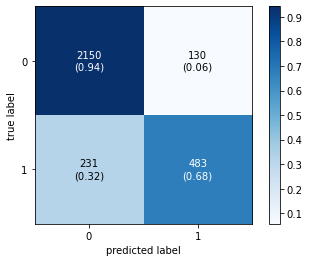

In [32]:
#LinearSVC
clf = LinearSVC()

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Support Vector Classifier
accuracy:   84.703
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2280
           1       0.92      0.39      0.55       714

    accuracy                           0.85      2994
   macro avg       0.88      0.69      0.73      2994
weighted avg       0.86      0.85      0.82      2994



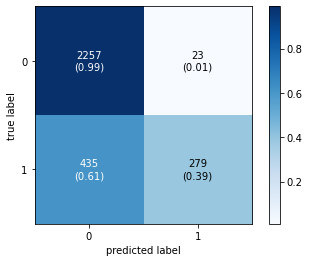

In [33]:
#SVC
clf = SVC()

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Passive Aggressive Classifier
accuracy:   87.007
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2280
           1       0.74      0.70      0.72       714

    accuracy                           0.87      2994
   macro avg       0.82      0.81      0.82      2994
weighted avg       0.87      0.87      0.87      2994



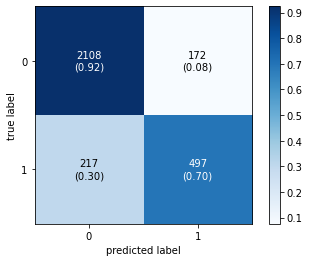

In [34]:
#PAC
clf = PassiveAggressiveClassifier(n_jobs=-1)

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Passive Aggressive Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

### A quick check on TFIDF only models for the same data splits

In [16]:
X_train = df_train_tfidf
X_test = df_test_tfidf
y_train = df_train['news_type'].copy()
y_test = df_test['news_type'].copy()

Support Vector Classifier
accuracy:   87.609
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2280
           1       0.78      0.66      0.72       714

    accuracy                           0.88      2994
   macro avg       0.84      0.80      0.82      2994
weighted avg       0.87      0.88      0.87      2994



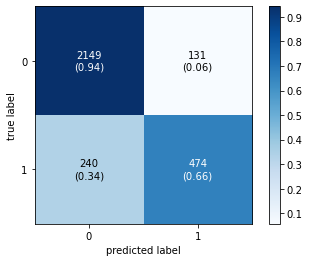

In [36]:
#LinearSVC
clf = LinearSVC()

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Support Vector Classifier
accuracy:   86.840
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2280
           1       0.83      0.56      0.67       714

    accuracy                           0.87      2994
   macro avg       0.85      0.76      0.79      2994
weighted avg       0.87      0.87      0.86      2994



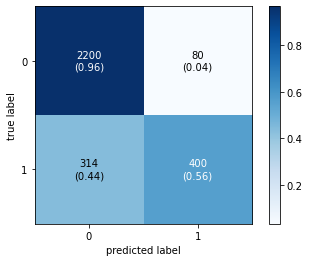

In [37]:
#SVC
clf = SVC()

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Passive Aggressive Classifier
accuracy:   87.575
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2280
           1       0.76      0.69      0.73       714

    accuracy                           0.88      2994
   macro avg       0.84      0.81      0.82      2994
weighted avg       0.87      0.88      0.87      2994



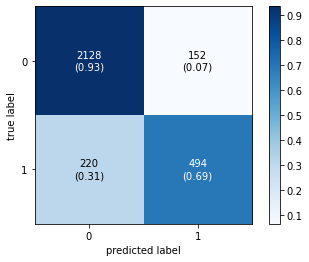

In [38]:
#PAC
clf = PassiveAggressiveClassifier(n_jobs=-1)

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Passive Aggressive Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# Dimension Reduction

We will consider reducing the dimensions into a 100 dimension space using the dimension reduction techniques of Singular Value Decomposition (SVD) and Partial Least Squares (PLS).

## a. Singular Value Decomposition (SVD)


### 1. dimension reduction (tfidf + metadata) (Type 1)

In this type, we will apply SVD on the concatenated feature set of TFIDF and metadata and derive 100 dimensions.

In [40]:
X_train = hstack((df_train_tfidf,df_train_rest))
X_test = hstack((df_test_tfidf,df_test_rest))
y_train = df_train['news_type'].copy()
y_test = df_test['news_type'].copy()

from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=100, random_state=99)

SVD_XMER = SVD.fit(X_train)

X_train = SVD_XMER.transform(X_train)
X_test = SVD_XMER.transform(X_test)

In [152]:
df_train_tfidf

<11974x3483556 sparse matrix of type '<class 'numpy.float64'>'
	with 6413409 stored elements in Compressed Sparse Row format>

Support Vector Classifier
accuracy:   85.137
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2280
           1       0.74      0.58      0.65       714

    accuracy                           0.85      2994
   macro avg       0.81      0.76      0.78      2994
weighted avg       0.84      0.85      0.85      2994



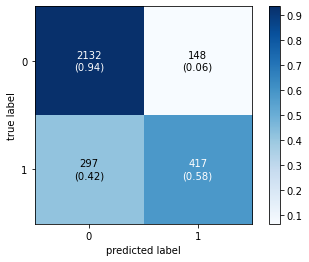

In [41]:
#LinearSVC
clf = LinearSVC()

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Support Vector Classifier
accuracy:   84.803
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2280
           1       0.91      0.40      0.56       714

    accuracy                           0.85      2994
   macro avg       0.88      0.69      0.73      2994
weighted avg       0.86      0.85      0.82      2994



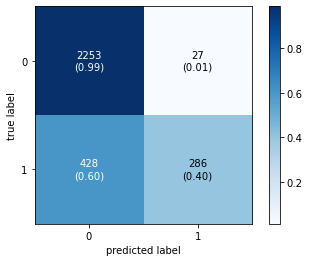

In [42]:
#SVC
clf = SVC()

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Passive Aggressive Classifier
accuracy:   67.836
              precision    recall  f1-score   support

           0       0.91      0.64      0.75      2280
           1       0.41      0.81      0.55       714

    accuracy                           0.68      2994
   macro avg       0.66      0.72      0.65      2994
weighted avg       0.79      0.68      0.70      2994



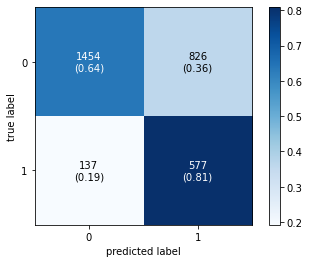

In [43]:
#PAC
clf = PassiveAggressiveClassifier(n_jobs=-1)

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Passive Aggressive Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

### 2. dimension reduction (tfidf only)

We will use only the TFIDF features this time.

In [44]:
X_train = df_train_tfidf
X_test = df_test_tfidf
y_train = df_train['news_type'].copy()
y_test = df_test['news_type'].copy()

from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=100, random_state=99)

SVD_XMER = SVD.fit(X_train)

X_train = SVD_XMER.transform(X_train)
X_test = SVD_XMER.transform(X_test)

Support Vector Classifier
accuracy:   86.005
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2280
           1       0.75      0.61      0.68       714

    accuracy                           0.86      2994
   macro avg       0.82      0.78      0.79      2994
weighted avg       0.85      0.86      0.85      2994



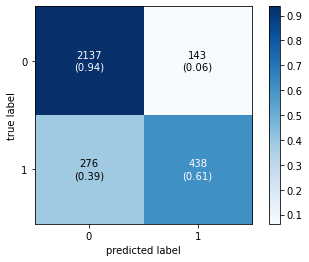

In [45]:
#LinearSVC
clf = LinearSVC()

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Support Vector Classifier
accuracy:   84.135
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2280
           1       0.73      0.54      0.62       714

    accuracy                           0.84      2994
   macro avg       0.80      0.74      0.76      2994
weighted avg       0.83      0.84      0.83      2994



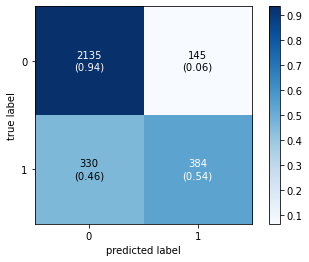

In [46]:
#SVC
clf = SVC()

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Passive Aggressive Classifier
accuracy:   86.306
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2280
           1       0.73      0.67      0.70       714

    accuracy                           0.86      2994
   macro avg       0.82      0.80      0.81      2994
weighted avg       0.86      0.86      0.86      2994



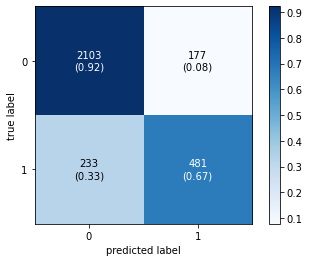

In [47]:
#PAC
clf = PassiveAggressiveClassifier(n_jobs=-1)

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Passive Aggressive Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

### 3. dimension reduction (tfidf) + metadata (Type 2)

In this type, we will apply SVD only on the TFIDF to derive 100 dimensions. Then those 100 dimensions will be concatenated with the binary encoded metadata features. This will greatly minimize the loss of information while still reducing the dimensions.

In [48]:
X_train = df_train_tfidf
X_test = df_test_tfidf
y_train = df_train['news_type'].copy()
y_test = df_test['news_type'].copy()

from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=100, random_state=99)

SVD_XMER = SVD.fit(X_train)

X_train = SVD_XMER.transform(X_train)
X_test = SVD_XMER.transform(X_test)

X_train = pd.concat([pd.DataFrame(X_train).reset_index(drop=True), pd.DataFrame(df_train_rest.toarray()).reset_index(drop=True)], ignore_index=True, sort=False, axis = 1)
X_test = pd.concat([pd.DataFrame(X_test).reset_index(drop=True), pd.DataFrame(df_test_rest.toarray()).reset_index(drop=True)], ignore_index=True, sort=False, axis = 1)


Support Vector Classifier
accuracy:   86.039
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2280
           1       0.75      0.62      0.68       714

    accuracy                           0.86      2994
   macro avg       0.82      0.78      0.80      2994
weighted avg       0.85      0.86      0.86      2994



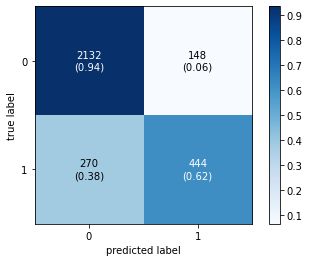

In [49]:
#LinearSVC
clf = LinearSVC()

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Support Vector Classifier
accuracy:   85.104
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2280
           1       0.92      0.41      0.57       714

    accuracy                           0.85      2994
   macro avg       0.88      0.70      0.74      2994
weighted avg       0.86      0.85      0.83      2994



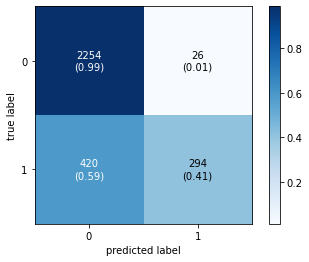

In [50]:
#SVC
clf = SVC()

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Passive Aggressive Classifier
accuracy:   83.567
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2280
           1       0.68      0.60      0.63       714

    accuracy                           0.84      2994
   macro avg       0.78      0.75      0.76      2994
weighted avg       0.83      0.84      0.83      2994



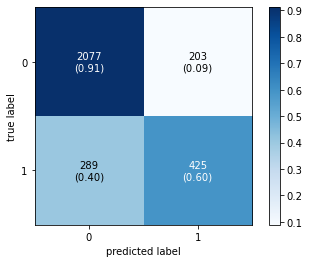

In [51]:
#PAC
clf = PassiveAggressiveClassifier(n_jobs=-1)

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Passive Aggressive Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

## b. Partial Least Squares

We will repeat all the previous steps for PLS. However since PLS cannot handle the bi-grams and tri-grams due to computational limitations, we limit the TFIDF to only unigrams.

In [61]:
df=fakenews_df.copy()
vec = CountVectorizer(input='content',strip_accents='unicode',lowercase=True,ngram_range=(1,1),max_df=0.70,min_df=1)
idf = TfidfTransformer()

In [62]:
df.drop('index',axis=1,inplace=True)
df.drop('text',axis=1,inplace=True)
df.drop('title',axis=1,inplace=True)
df.drop('proper_nouns',axis=1,inplace=True)
df.drop('verbs',axis=1,inplace=True)
df.drop('adj',axis=1,inplace=True)
df.drop('ner',axis=1,inplace=True)
df.drop('adverbs',axis=1,inplace=True)
df.drop('site_name',axis=1,inplace=True)
df.drop('text_length',axis=1,inplace=True)
df.drop('type',axis=1,inplace=True)
df.drop('authors',axis=1,inplace=True)

df['normal_text'] = 6 * (df.normal_title) + df.normal_text
df['news_type'] = fakenews_df.fake.apply(int).tolist()
df['normal_text'] = df['normal_text'].apply(' '.join)

df.drop('fake',axis=1,inplace=True)
df.drop('normal_title',axis=1,inplace=True)


In [63]:
# splitting data for training and testing

np.random.seed(11)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1) 

In [64]:
pipe_tfidf = Pipeline([
    ('vect', vec),
    ('tfidf', idf)
])

In [65]:
pipe_trained_tfidf = pipe_tfidf.fit(df_train['normal_text'])

In [66]:
df_train_tfidf = pipe_trained_tfidf.transform(df_train['normal_text'])
df_test_tfidf = pipe_trained_tfidf.transform(df_test['normal_text'])

In [67]:
df_train_rest=df_train.copy()
df_train_rest.drop('normal_text',axis=1,inplace=True)
df_train_rest.drop('news_type',axis=1,inplace=True)
#df_train_rest.drop('scaled_text_length',axis=1,inplace=True)

df_test_rest=df_test.copy()
df_test_rest.drop('normal_text',axis=1,inplace=True)
df_test_rest.drop('news_type',axis=1,inplace=True)
#df_test_rest.drop('scaled_text_length',axis=1,inplace=True)

df_train_rest = scipy.sparse.csr_matrix(df_train_rest.values).copy() #convert df to array using values and then to sparse matrix
df_test_rest = scipy.sparse.csr_matrix(df_test_rest.values).copy()

### dimension reduction (tfidf + metadata) (Type 1)

In [68]:
X_train = hstack((df_train_tfidf,df_train_rest))
X_test = hstack((df_test_tfidf,df_test_rest))
y_train = df_train['news_type'].copy()
y_test = df_test['news_type'].copy()

from sklearn.cross_decomposition import PLSRegression
PLS1 = PLSRegression(n_components=100)

PLS1_XMER = PLS1.fit(X_train.toarray(),y_train)

X_train = PLS1_XMER.transform(X_train.toarray())
X_test = PLS1_XMER.transform(X_test.toarray())


C:\ProgramData\Anaconda3\envs\NLP Project\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Support Vector Classifier
accuracy:   58.417
              precision    recall  f1-score   support

           0       0.84      0.56      0.67      2280
           1       0.32      0.65      0.43       714

    accuracy                           0.58      2994
   macro avg       0.58      0.61      0.55      2994
weighted avg       0.71      0.58      0.61      2994



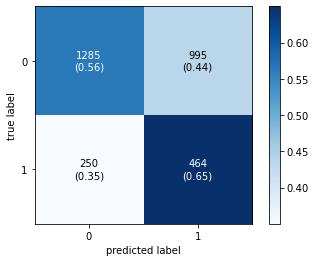

In [69]:
#LinearSVC
clf = LinearSVC()

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Support Vector Classifier
accuracy:   80.628
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      2280
           1       0.63      0.46      0.53       714

    accuracy                           0.81      2994
   macro avg       0.74      0.69      0.70      2994
weighted avg       0.79      0.81      0.79      2994



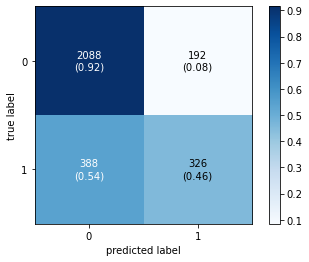

In [70]:
#SVC
clf = SVC()

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Passive Aggressive Classifier
accuracy:   57.448
              precision    recall  f1-score   support

           0       0.84      0.55      0.66      2280
           1       0.31      0.66      0.43       714

    accuracy                           0.57      2994
   macro avg       0.58      0.60      0.54      2994
weighted avg       0.71      0.57      0.61      2994



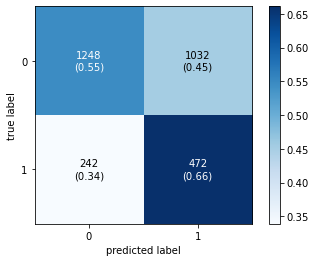

In [71]:
#PAC
clf = PassiveAggressiveClassifier(n_jobs=-1)

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Passive Aggressive Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

### dimension reduction (tfidf)

In [72]:
X_train = df_train_tfidf
X_test = df_test_tfidf
y_train = df_train['news_type'].copy()
y_test = df_test['news_type'].copy()

from sklearn.cross_decomposition import PLSRegression
PLS1 = PLSRegression(n_components=100)

PLS1_XMER = PLS1.fit(X_train.toarray(),y_train)

X_train = PLS1_XMER.transform(X_train.toarray())
X_test = PLS1_XMER.transform(X_test.toarray())

C:\ProgramData\Anaconda3\envs\NLP Project\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Support Vector Classifier
accuracy:   58.450
              precision    recall  f1-score   support

           0       0.85      0.55      0.67      2280
           1       0.32      0.68      0.44       714

    accuracy                           0.58      2994
   macro avg       0.59      0.62      0.55      2994
weighted avg       0.72      0.58      0.61      2994



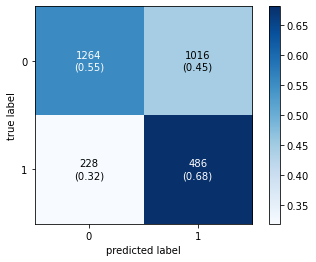

In [73]:
#LinearSVC
clf = LinearSVC()

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Support Vector Classifier
accuracy:   78.724
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      2280
           1       0.60      0.31      0.41       714

    accuracy                           0.79      2994
   macro avg       0.71      0.62      0.64      2994
weighted avg       0.76      0.79      0.76      2994



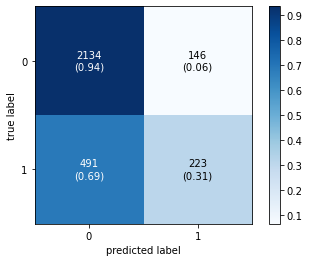

In [74]:
#SVC
clf = SVC()

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Passive Aggressive Classifier
accuracy:   55.043
              precision    recall  f1-score   support

           0       0.83      0.51      0.63      2280
           1       0.30      0.67      0.42       714

    accuracy                           0.55      2994
   macro avg       0.57      0.59      0.53      2994
weighted avg       0.71      0.55      0.58      2994



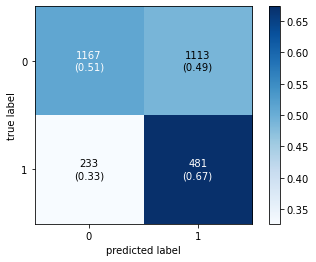

In [75]:
#PAC
clf = PassiveAggressiveClassifier(n_jobs=-1)

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Passive Aggressive Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

### dimension reduction (tfidf) + metadata

In [76]:
X_train = df_train_tfidf
X_test = df_test_tfidf
y_train = df_train['news_type'].copy()
y_test = df_test['news_type'].copy()

from sklearn.cross_decomposition import PLSRegression
PLS1 = PLSRegression(n_components=100)

PLS1_XMER = PLS1.fit(X_train.toarray(),y_train)

X_train = PLS1_XMER.transform(X_train.toarray())
X_test = PLS1_XMER.transform(X_test.toarray())

X_train = pd.concat([pd.DataFrame(X_train).reset_index(drop=True), pd.DataFrame(df_train_rest.toarray()).reset_index(drop=True)], ignore_index=True, sort=False, axis = 1)
X_test = pd.concat([pd.DataFrame(X_test).reset_index(drop=True), pd.DataFrame(df_test_rest.toarray()).reset_index(drop=True)], ignore_index=True, sort=False, axis = 1)


C:\ProgramData\Anaconda3\envs\NLP Project\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Support Vector Classifier
accuracy:   60.488
              precision    recall  f1-score   support

           0       0.83      0.60      0.70      2280
           1       0.32      0.61      0.42       714

    accuracy                           0.60      2994
   macro avg       0.58      0.60      0.56      2994
weighted avg       0.71      0.60      0.63      2994



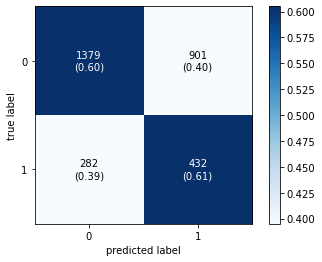

In [77]:
#LinearSVC
clf = LinearSVC()

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Support Vector Classifier
accuracy:   78.858
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      2280
           1       0.61      0.31      0.41       714

    accuracy                           0.79      2994
   macro avg       0.71      0.63      0.64      2994
weighted avg       0.77      0.79      0.76      2994



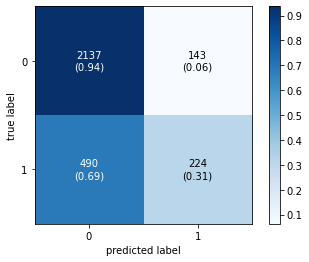

In [78]:
#SVC
clf = SVC()

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Passive Aggressive Classifier
accuracy:   66.566
              precision    recall  f1-score   support

           0       0.86      0.67      0.75      2280
           1       0.38      0.65      0.48       714

    accuracy                           0.67      2994
   macro avg       0.62      0.66      0.62      2994
weighted avg       0.75      0.67      0.69      2994



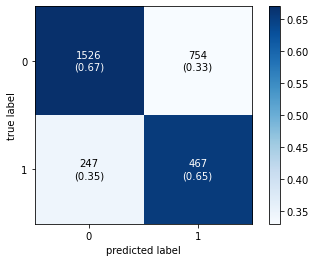

In [79]:
#PAC
clf = PassiveAggressiveClassifier(n_jobs=-1)

model = clf.fit(X_train, y_train)
prediction = model.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Passive Aggressive Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# Hyper parameter tuning for SVC

### We use the SVD reduced dimension space (n=100) that were derived only from the TFIDF as input.

In [8]:
df=fakenews_df.copy()
vec = CountVectorizer(input='content',strip_accents='unicode',lowercase=True,ngram_range=(1,3),max_df=0.70,min_df=1)
idf = TfidfTransformer()

In [9]:
df.drop('index',axis=1,inplace=True)
df.drop('text',axis=1,inplace=True)
df.drop('title',axis=1,inplace=True)
df.drop('proper_nouns',axis=1,inplace=True)
df.drop('verbs',axis=1,inplace=True)
df.drop('adj',axis=1,inplace=True)
df.drop('ner',axis=1,inplace=True)
df.drop('adverbs',axis=1,inplace=True)
df.drop('site_name',axis=1,inplace=True)
df.drop('text_length',axis=1,inplace=True)
df.drop('type',axis=1,inplace=True)
df.drop('authors',axis=1,inplace=True)

df['normal_text'] = 6 * (df.normal_title) + df.normal_text
df['news_type'] = fakenews_df.fake.apply(int).tolist()
df['normal_text'] = df['normal_text'].apply(' '.join)

df.drop('fake',axis=1,inplace=True)
df.drop('normal_title',axis=1,inplace=True)


In [10]:
# splitting data for training and testing

np.random.seed(11)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1) 

In [11]:
pipe_tfidf = Pipeline([
    ('vect', vec),
    ('tfidf', idf)
])

In [12]:
pipe_trained_tfidf = pipe_tfidf.fit(df_train['normal_text'])

In [13]:
df_train_tfidf = pipe_trained_tfidf.transform(df_train['normal_text'])
df_test_tfidf = pipe_trained_tfidf.transform(df_test['normal_text'])

In [14]:
df_train_rest=df_train.copy()
df_train_rest.drop('normal_text',axis=1,inplace=True)
df_train_rest.drop('news_type',axis=1,inplace=True)
#df_train_rest.drop('scaled_text_length',axis=1,inplace=True)

df_test_rest=df_test.copy()
df_test_rest.drop('normal_text',axis=1,inplace=True)
df_test_rest.drop('news_type',axis=1,inplace=True)
#df_test_rest.drop('scaled_text_length',axis=1,inplace=True)

df_train_rest = scipy.sparse.csr_matrix(df_train_rest.values).copy() #convert df to array using values and then to sparse matrix
df_test_rest = scipy.sparse.csr_matrix(df_test_rest.values).copy()

In [143]:
X_train = df_train_tfidf
X_test = df_test_tfidf
y_train = df_train['news_type'].copy()
y_test = df_test['news_type'].copy()

from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=100, random_state=99)

SVD_XMER = SVD.fit(X_train)

X_train = SVD_XMER.transform(X_train)
X_test = SVD_XMER.transform(X_test)

## Radial Kernels

In [90]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, scoring=['recall','f1'], refit = 'f1', verbose = 3, n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  4.9min finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             refit='f1', scoring=['recall', 'f1'], verbose=3)

In [92]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1000, gamma=1)


Support Vector Classifier
accuracy:   84.369
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2280
           1       0.68      0.64      0.66       714

    accuracy                           0.84      2994
   macro avg       0.79      0.77      0.78      2994
weighted avg       0.84      0.84      0.84      2994



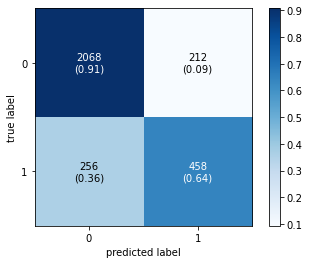

In [91]:
prediction = grid.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [96]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  5.2min finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [97]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.1)


Support Vector Classifier
accuracy:   86.774
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      2280
           1       0.78      0.63      0.69       714

    accuracy                           0.87      2994
   macro avg       0.83      0.78      0.80      2994
weighted avg       0.86      0.87      0.86      2994



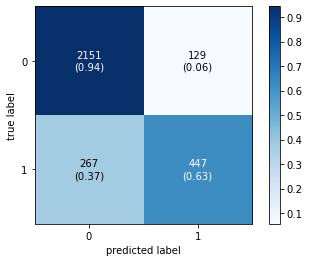

In [98]:
prediction = grid.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [99]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [10, 100, 1000, 10000, 100000],  
              'gamma': [10, 1, 0.1, 0.01], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, scoring='recall', refit = True, verbose = 3, n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.2min finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [10, 100, 1000, 10000, 100000],
                         'gamma': [10, 1, 0.1, 0.01], 'kernel': ['rbf']},
             scoring='recall', verbose=3)

In [100]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 10000, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10000, gamma=1)


Support Vector Classifier
accuracy:   81.997
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2280
           1       0.62      0.64      0.63       714

    accuracy                           0.82      2994
   macro avg       0.75      0.76      0.75      2994
weighted avg       0.82      0.82      0.82      2994



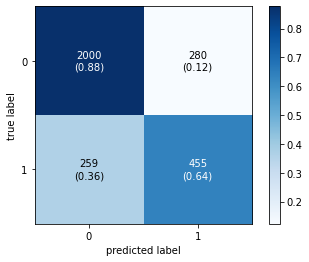

In [101]:
prediction = grid.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

## Linear Kernel

In [117]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [10, 100, 1000, 10000],  
              'kernel': ['linear']}  
  
#grid = GridSearchCV(SVC(), param_grid, scoring='f1', refit = True, verbose = 3, n_jobs=-1) 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, n_jobs=-1) 

# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:   44.5s remaining:   29.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.1min finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [10, 100, 1000, 10000], 'kernel': ['linear']},
             verbose=3)

In [118]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1000, 'kernel': 'linear'}
SVC(C=1000, kernel='linear')


Support Vector Classifier
accuracy:   86.339
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2280
           1       0.76      0.62      0.68       714

    accuracy                           0.86      2994
   macro avg       0.82      0.78      0.80      2994
weighted avg       0.86      0.86      0.86      2994



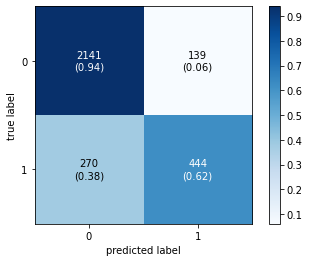

In [119]:
prediction = grid.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

## Polynomial Kernel

In [114]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [100, 1000, 10000],
              'gamma': [10, 1, 0.1, 0.01],
              'degree': [1,2,3],  
              'kernel': ['poly']}  
  
grid = GridSearchCV(SVC(), param_grid, scoring='f1', refit = True, verbose = 3, n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 24.2min finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [100, 1000, 10000], 'degree': [1, 2, 3],
                         'gamma': [10, 1, 0.1, 0.01], 'kernel': ['poly']},
             scoring='f1', verbose=3)

In [115]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 10000, 'degree': 1, 'gamma': 10, 'kernel': 'poly'}
SVC(C=10000, degree=1, gamma=10, kernel='poly')


Support Vector Classifier
accuracy:   86.373
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2280
           1       0.76      0.62      0.69       714

    accuracy                           0.86      2994
   macro avg       0.83      0.78      0.80      2994
weighted avg       0.86      0.86      0.86      2994



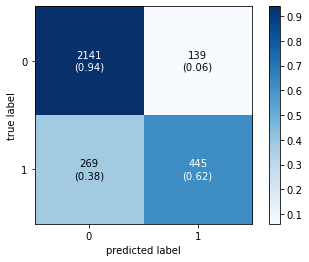

In [116]:
prediction = grid.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [120]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [1000, 10000],
              'gamma': [10, 1, 0.1],
              'degree': [1,2,3],  
              'kernel': ['poly']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 16.4min finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1000, 10000], 'degree': [1, 2, 3],
                         'gamma': [10, 1, 0.1], 'kernel': ['poly']},
             verbose=3)

In [121]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1000, 'degree': 1, 'gamma': 1, 'kernel': 'poly'}
SVC(C=1000, degree=1, gamma=1, kernel='poly')


Support Vector Classifier
accuracy:   86.339
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2280
           1       0.76      0.62      0.68       714

    accuracy                           0.86      2994
   macro avg       0.82      0.78      0.80      2994
weighted avg       0.86      0.86      0.86      2994



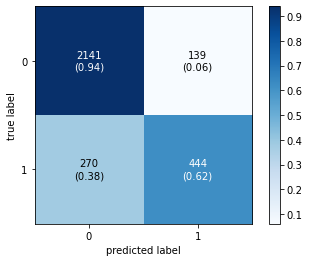

In [122]:
prediction = grid.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [125]:
grid.scorer_ #euclidean distance scorer (default)

<function sklearn.metrics._scorer._passthrough_scorer(estimator, *args, **kwargs)>

In [126]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,112.787910,3.178849,1.388499,0.173247,1000,1,10,poly,"{'C': 1000, 'degree': 1, 'gamma': 10, 'kernel'...",0.863466,0.856785,0.848017,0.850104,0.864244,0.856523,0.006655,3
1,24.616863,1.691626,1.552020,0.157665,1000,1,1,poly,"{'C': 1000, 'degree': 1, 'gamma': 1, 'kernel':...",0.863466,0.857203,0.848017,0.849687,0.864662,0.856607,0.006840,1
2,12.519322,0.817966,1.523671,0.064958,1000,1,0.1,poly,"{'C': 1000, 'degree': 1, 'gamma': 0.1, 'kernel...",0.860125,0.854697,0.846764,0.848434,0.863409,0.854686,0.006442,6
3,50.549276,1.991566,1.434686,0.101605,1000,2,10,poly,"{'C': 1000, 'degree': 2, 'gamma': 10, 'kernel'...",0.825052,0.805010,0.813361,0.798330,0.817460,0.811843,0.009356,14
4,14.423612,0.876648,1.777551,0.144068,1000,2,1,poly,"{'C': 1000, 'degree': 2, 'gamma': 1, 'kernel':...",0.853445,0.851775,0.848852,0.843006,0.856307,0.850677,0.004533,7
5,13.764240,0.255771,2.110972,0.157984,1000,2,0.1,poly,"{'C': 1000, 'degree': 2, 'gamma': 0.1, 'kernel...",0.812944,0.812526,0.805010,0.814614,0.818296,0.812678,0.004340,13
6,23.627445,0.795514,1.772898,0.089468,1000,3,10,poly,"{'C': 1000, 'degree': 3, 'gamma': 10, 'kernel'...",0.823382,0.807098,0.817119,0.810856,0.835840,0.818859,0.010141,12
7,14.081080,1.226952,2.164235,0.207671,1000,3,1,poly,"{'C': 1000, 'degree': 3, 'gamma': 1, 'kernel':...",0.830480,0.816284,0.817119,0.822965,0.830827,0.823535,0.006253,11
8,16.021615,0.328843,2.433106,0.161492,1000,3,0.1,poly,"{'C': 1000, 'degree': 3, 'gamma': 0.1, 'kernel...",0.757829,0.757411,0.757411,0.757411,0.757728,0.757558,0.000183,18
9,779.203534,11.936540,0.962043,0.052036,10000,1,10,poly,"{'C': 10000, 'degree': 1, 'gamma': 10, 'kernel...",0.863883,0.856367,0.848017,0.850104,0.864244,0.856523,0.006743,3


## Tuning Class weights

Support Vector Classifier
accuracy:   81.663
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      2280
           1       0.58      0.81      0.68       714

    accuracy                           0.82      2994
   macro avg       0.76      0.81      0.77      2994
weighted avg       0.85      0.82      0.83      2994



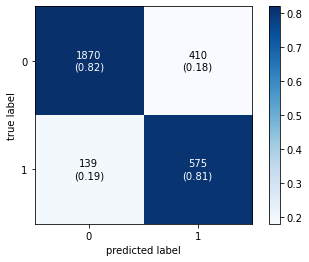

In [146]:
clf=SVC(C=1000, degree=1, gamma=1, kernel='poly', class_weight={1:3})
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Support Vector Classifier
accuracy:   82.832
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      2280
           1       0.60      0.82      0.69       714

    accuracy                           0.83      2994
   macro avg       0.77      0.82      0.79      2994
weighted avg       0.86      0.83      0.84      2994



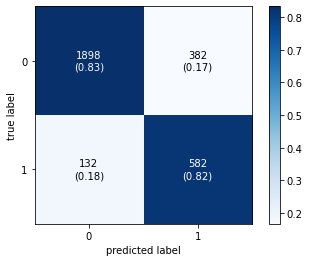

In [147]:
clf=SVC(C=1000, gamma=0.1, class_weight={1:3})
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Support Vector Classifier
accuracy:   81.663
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      2280
           1       0.58      0.81      0.68       714

    accuracy                           0.82      2994
   macro avg       0.76      0.81      0.77      2994
weighted avg       0.85      0.82      0.83      2994



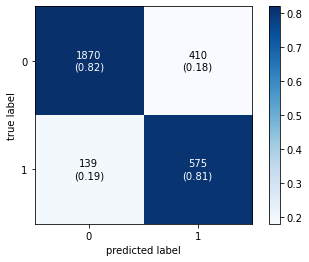

In [150]:
clf=SVC(C=1000, kernel='linear', class_weight={1:3})
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)

score = metrics.accuracy_score(y_test, prediction)
f1score = metrics.classification_report(y_test, prediction)
print('Support Vector Classifier')
print("accuracy:   %0.3f" % (score * 100))
print(f1score)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# GridSearchCV

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#CountVectorizer(input='content',strip_accents='unicode',lowercase=True,ngram_range=(1,3),max_df=1.0,min_df=1)
def get_tfidf(in_text_series):
    #bow_transformer=CountVectorizer(input='content',strip_accents='unicode',lowercase=True,ngram_range=(1,1),max_df=1.0,min_df=1).fit(in_text_series.apply(' '.join))
    bow_transformer=CountVectorizer(input='content', max_features=500, strip_accents='unicode',lowercase=True,ngram_range=(1,1),max_df=1.0,min_df=1).fit(in_text_series.apply(' '.join))
    text_bow = bow_transformer.transform(in_text_series.apply(' '.join))
    tfidf_transformer = TfidfTransformer().fit(text_bow)
    text_tfidf = tfidf_transformer.transform(text_bow)
    return {'text_tfidf':text_tfidf, 'bow_transformer':bow_transformer, 'tfidf_transformer':tfidf_transformer}

In [16]:
normal_text_tfidf = get_tfidf(fakenews_df['normal_text'])
normal_text_tfidf = pd.DataFrame(normal_text_tfidf['text_tfidf'].toarray())
normal_text_tfidf

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.116214,0.096140,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,...,0.000000,0.078553,0.000000,0.074274,0.051124,0.0,0.000000,0.000000,0.046195,0.000000
2,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.029222,0.00000,...,0.000000,0.000000,0.023036,0.000000,0.038164,0.0,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.164682,0.113355,0.0,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.0,0.103102,0.187225,0.000000,0.0,0.0,0.000000,0.079526,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.103860,0.0,0.000000,0.167882,0.187692,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14963,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.091287,0.00000,...,0.158319,0.000000,0.000000,0.000000,0.059610,0.0,0.000000,0.000000,0.000000,0.000000
14964,0.000000,0.0,0.000000,0.000000,0.058484,0.0,0.0,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
14965,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
14966,0.035914,0.0,0.038212,0.069390,0.000000,0.0,0.0,0.000000,0.000000,0.06176,...,0.025559,0.000000,0.000000,0.027961,0.019247,0.0,0.034472,0.000000,0.000000,0.000000


In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(normal_text_tfidf, fakenews_df['fake'], test_size=0.2, random_state=2)

In [18]:
# GridSearchCV for LinearSVC

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10.0], 'loss': ['hinge', 'squared_hinge'], 'penalty': ['l1', 'l2']}
grid = GridSearchCV(LinearSVC(), param_grid, verbose=3)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=0.001, loss=hinge, penalty=l1 .................................
[CV] ....... C=0.001, loss=hinge, penalty=l1, score=nan, total=   0.0s
[CV] C=0.001, loss=hinge, penalty=l1 .................................
[CV] ....... C=0.001, loss=hinge, penalty=l1, score=nan, total=   0.0s
[CV] C=0.001, loss=hinge, penalty=l1 .................................
[CV] ....... C=0.001, loss=hinge, penalty=l1, score=nan, total=   0.0s
[CV] C=0.001, loss=hinge, penalty=l1 .................................
[CV] ....... C=0.001, loss=hinge, penalty=l1, score=nan, total=   0.1s
[CV] C=0.001, loss=hinge, penalty=l1 .................................
[CV] ....... C=0.001, loss=hinge, penalty=l1, score=nan, total=   0.1s
[CV] C=0.001, loss=hinge, penalty=l2 .................................
[CV] ..... C=0.001, loss=hinge, penalty=l2, score=0.757, total=   0.1s
[CV] C=0.001, loss=hinge, penalty=l2 .................................
[CV] ..... C=0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\users\torst\anaconda3\envs\course2groupproject\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\torst\anaconda3\envs\course2groupproject\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\torst\anaconda3\envs\course2groupproject\lib\site-packages\sklearn\svm\_classes.py", line 237, in fit
    self.loss, sample_weight=sample_weight)
  File "c:\users\torst\anaconda3\envs\course2groupproject\lib\site-packages\sklearn\svm\_base.py", line 965, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "c:\users\torst\anaconda3\envs\course2groupproject\lib\site-packages\sk

GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l1', 'l2']},
             verbose=3)

In [19]:
grid.best_params_

{'C': 1.0, 'loss': 'hinge', 'penalty': 'l2'}

[[2189   97]
 [ 319  389]]


              precision    recall  f1-score   support

       False       0.87      0.96      0.91      2286
        True       0.80      0.55      0.65       708

    accuracy                           0.86      2994
   macro avg       0.84      0.75      0.78      2994
weighted avg       0.86      0.86      0.85      2994



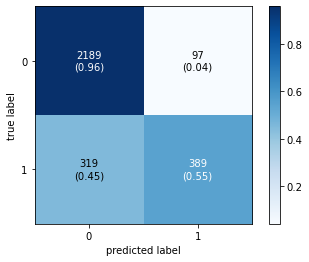

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
#% matplotlib inline
from sklearn.svm import LinearSVC
svm = LinearSVC()
svm.fit(x_train, y_train)
predictions = svm.predict(x_test)
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, predictions),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

[[2186  100]
 [ 314  394]]


              precision    recall  f1-score   support

       False       0.87      0.96      0.91      2286
        True       0.80      0.56      0.66       708

    accuracy                           0.86      2994
   macro avg       0.84      0.76      0.78      2994
weighted avg       0.86      0.86      0.85      2994



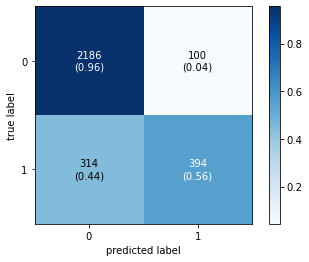

In [22]:
svm = LinearSVC(C=10, loss='squared_hinge', penalty='l2')
svm.fit(x_train, y_train)
predictions = svm.predict(x_test)
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, predictions),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [23]:
# GridSearchCV for PassiveAggressiveClassifier

from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.003, 0.01, 0.03, 0.1, 0.3, 1, 3], 'loss': ['hinge', 'squared_hinge']}
grid = GridSearchCV(PassiveAggressiveClassifier(), param_grid, verbose=3)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] C=0.003, loss=hinge .............................................
[CV] ................. C=0.003, loss=hinge, score=0.849, total=   0.6s
[CV] C=0.003, loss=hinge .............................................
[CV] ................. C=0.003, loss=hinge, score=0.848, total=   1.2s
[CV] C=0.003, loss=hinge .............................................
[CV] ................. C=0.003, loss=hinge, score=0.850, total=   0.7s
[CV] C=0.003, loss=hinge .............................................
[CV] ................. C=0.003, loss=hinge, score=0.833, total=   0.9s
[CV] C=0.003, loss=hinge .............................................
[CV] ................. C=0.003, loss=hinge, score=0.849, total=   0.7s
[CV] C=0.003, loss=squared_hinge .....................................
[CV] ......... C=0.003, loss=squared_hinge, score=0.848, total=   1.1s
[CV] C=0.003, loss=squared_hinge .....................................
[CV] ......... C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   33.2s finished


GridSearchCV(estimator=PassiveAggressiveClassifier(),
             param_grid={'C': [0.003, 0.01, 0.03, 0.1, 0.3, 1, 3],
                         'loss': ['hinge', 'squared_hinge']},
             verbose=3)

In [24]:
grid.best_params_

{'C': 0.01, 'loss': 'hinge'}

[[2198   88]
 [ 370  338]]


              precision    recall  f1-score   support

       False       0.86      0.96      0.91      2286
        True       0.79      0.48      0.60       708

    accuracy                           0.85      2994
   macro avg       0.82      0.72      0.75      2994
weighted avg       0.84      0.85      0.83      2994



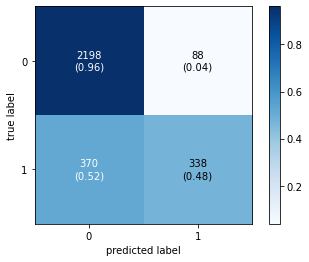

In [25]:
pac = PassiveAggressiveClassifier()
#svm = SVC(C=10, gamma=0.001)
pac.fit(x_train, y_train)
predictions = pac.predict(x_test)
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, predictions),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

[[2059  227]
 [ 242  466]]


              precision    recall  f1-score   support

       False       0.89      0.90      0.90      2286
        True       0.67      0.66      0.67       708

    accuracy                           0.84      2994
   macro avg       0.78      0.78      0.78      2994
weighted avg       0.84      0.84      0.84      2994



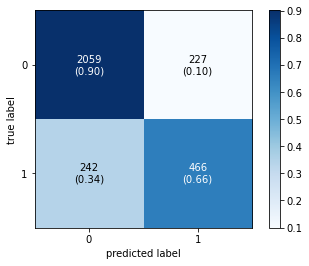

In [26]:
pac = PassiveAggressiveClassifier(C=0.03, loss='squared_hinge')
#svm = SVC(C=10, gamma=0.001)
pac.fit(x_train, y_train)
predictions = pac.predict(x_test)
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, predictions),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [27]:
# GridSearchCV for Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
param_grid = {'penalty':['l1', 'l2'], 'C': np.logspace(-4, 4, 20),
              'solver': ['liblinear', 'newton-cg']}
grid = GridSearchCV(LogisticRegression(), param_grid, verbose=3)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] C=0.0001, penalty=l1, solver=liblinear ..........................
[CV]  C=0.0001, penalty=l1, solver=liblinear, score=0.757, total=   0.2s
[CV] C=0.0001, penalty=l1, solver=liblinear ..........................
[CV]  C=0.0001, penalty=l1, solver=liblinear, score=0.757, total=   0.1s
[CV] C=0.0001, penalty=l1, solver=liblinear ..........................
[CV]  C=0.0001, penalty=l1, solver=liblinear, score=0.757, total=   0.1s
[CV] C=0.0001, penalty=l1, solver=liblinear ..........................
[CV]  C=0.0001, penalty=l1, solver=liblinear, score=0.757, total=   0.2s
[CV] C=0.0001, penalty=l1, solver=liblinear ..........................
[CV]  C=0.0001, penalty=l1, solver=liblinear, score=0.757, total=   0.1s
[CV] C=0.0001, penalty=l1, solver=newton-cg ..........................
[CV]  C=0.0001, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.0001, penalty=l1, solver=newton-cg ..........................
[CV] 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
c:\users\torst\anaconda3\envs\course2groupproject\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\torst\anaconda3\envs\course2groupproject\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\torst\anaconda3\envs\course2groupproject\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\users\torst\anaconda3\envs\course2groupproject\lib\site-packages\sklearn\linear_m

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'newton-cg']},
             verbose=3)

In [28]:
grid.best_params_

{'C': 0.615848211066026, 'penalty': 'l2', 'solver': 'liblinear'}

[[2201   85]
 [ 326  382]]


              precision    recall  f1-score   support

       False       0.87      0.96      0.91      2286
        True       0.82      0.54      0.65       708

    accuracy                           0.86      2994
   macro avg       0.84      0.75      0.78      2994
weighted avg       0.86      0.86      0.85      2994



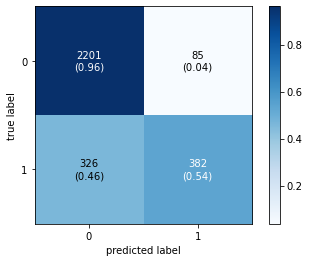

In [29]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train, y_train)
predictions = lr.predict(x_test)
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, predictions),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

[[2165  121]
 [ 306  402]]


              precision    recall  f1-score   support

       False       0.88      0.95      0.91      2286
        True       0.77      0.57      0.65       708

    accuracy                           0.86      2994
   macro avg       0.82      0.76      0.78      2994
weighted avg       0.85      0.86      0.85      2994



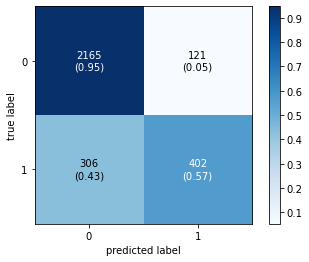

In [30]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=11.3, penalty='l1', solver='liblinear')
#lr = LogisticRegression(C=0.62, penalty='l1', solver='liblinear')
lr.fit(x_train, y_train)
predictions = lr.predict(x_test)
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, predictions),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()
